In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
import operator


# Loading the Dataset

In [3]:
file_path = 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories'
folder_names = []
folder_names = [f for f in sorted(os.listdir(file_path))]

print(len(folder_names))  # 102 = 101 categories + background


102


C:\Users\Joe\AppData\Local\Temp\ipykernel_17644\2155978937.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


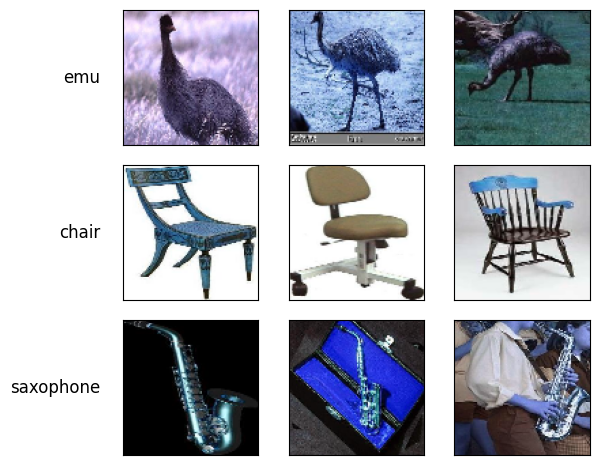

In [4]:
num_categories = 3
num_imgs = 3 
selected_categories = np.random.randint(0,101, num_categories, dtype="I")

fig, ax = plt.subplots(nrows=num_categories, ncols=num_imgs)

fig.subplots_adjust(wspace=0.1,hspace=0.1)

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))][:num_imgs]
    
    for b, img_name in enumerate(image_names):
        img_path = folder_path + '/' + img_name
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        ax[a, b].imshow(img)
        ax[a, b].set_xticks([])
        ax[a, b].set_yticks([])
        
        if b == 0:
            pad = 5  # in points
            #ax[i,j].set_ylabel(folder_names[category], rotation=0, size='large')
            ax[a,b].annotate(folder_names[cat], xy=(0, 0.5), xytext=(-ax[a,b].yaxis.labelpad - pad, 0),
                xycoords=ax[a,b].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
fig.tight_layout()
#plt.axis('off')
fig.show()


In [5]:
img_data = []
img_money = []
num_categories = 6
num_imgs = 9
selected_categories = np.random.randint(0,101, num_categories, dtype="I")

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))][:num_imgs]

    for b, img_name in enumerate(image_names):
        img_path = folder_path + '/' + img_name
        img_money.append(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        
        if img is not None:
            img_data.append(img)
       


# Global Functions

In [6]:
def normalise(distances, scale):
    scaler = MinMaxScaler((0, scale))
    keys = distances.keys()
    distances = np.array(list(distances.values()))
    distances = scaler.fit_transform(distances.reshape(-1, 1))
    distances = dict(zip(keys, distances))
    return distances

# Histogram features

In [7]:
def histogram_features(img):
    features = [] 
    pp_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    channels = cv2.split(pp_img)
    channel_names = ('h', 's', 'v')
    for (channel, channel_name) in zip(channels, channel_names):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        features.extend(hist.flatten())
        return features

In [8]:
def hist_features_database(data_imgs):
    db_features = []
    for img in data_imgs:
        db_features.append(histogram_features(img))
    db_hist_df = DataFrame(db_features)
    return db_hist_df

In [9]:
def calc_hist_distance(query_img, db_df):
    feature_vectors = db_df.values.tolist()
    distances = {}
    for a in range(len(feature_vectors)):
        query_features = histogram_features(query_img)
        dist = euclidean(query_features, feature_vectors[a])
        distances[a] = dist
    return normalise(distances, 20)

# Gabor Features

In [10]:
def build_filters():
    filters = []
    kernal_size = 9 
    for theta in np.arange(0, np.pi, np.pi / 8):
        for deg in np.arange(0, 6*np.pi/4, np.pi / 4):
            kernal = cv2.getGaborKernel((kernal_size, kernal_size), 1.0, theta, deg, 0.5, 0, ktype= cv2.CV_32F)
            kernal /= 1.5 * kernal.sum()
            filters.append(kernal)
    return filters

In [11]:
def convolve_filters(img, filters):
    conv = np.zeros_like(img)
    for kernal in filters:
        filter_img = cv2.filter2D(img, cv2.CV_8UC3, kernal)
        np.maximum(conv, filter_img, conv)
    return conv

In [12]:
def gabor_features(img):
    features = []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filters = np.asarray(build_filters())
    
    for a in range(20):
        energy = 0
        conv = convolve_filters(img, filters[a])
        for b in range(100):
            for c in range(100):
                energy += conv[b][c] * conv[b][c]
        features.append(energy)
    for a in range(20):
        mean = 0
        conv = convolve_filters(img, filters[a])
        for b in range(100):
            for c in range(100):
                mean += abs(conv[a][b])
        features.append(mean)
    features = np.array(features)
    return features

In [13]:
def gabor_features_database(data_imgs):
    db_feat = []
    for img in data_imgs:
        db_feat.append(gabor_features(img))
    db_gabor_df = DataFrame(db_feat)
    return db_gabor_df

In [14]:
def calc_gabor_distance(query_img, db_df):
    distances = {}
    query_feat = gabor_features(query_img)
    feature_vector = db_df.values.tolist()
    
    for a in range(len(feature_vector)):
        distances[a] = euclidean(query_feat, feature_vector[a])
    distances = normalise(distances, 20)
    return distances

# Distance Metric Calculation

In [15]:
def calc_distances_total(hist_dist, gabor_dist):
    total_dist = []
    hist_weight = 0.8
    gabor_weight = 0.2
    
    for a in hist_dist:
        hist_dist[a] *= hist_weight
        gabor_dist[a] *= gabor_weight
        total_dist.append(hist_dist[a] + gabor_dist[a])  
    return sorted(dict(zip(np.arange(0, len(img_data)), (np.array(total_dist)))).items(), key=operator.itemgetter(1))


In [16]:
query_img = img_data[0]

hist_dist = calc_hist_distance(query_img, hist_features_database(img_data))
gabor_dist = calc_gabor_distance(query_img, gabor_features_database(img_data))

final_dist = calc_distances_total(hist_dist, gabor_dist)

C:\Users\Joe\AppData\Local\Temp\ipykernel_17644\1623920403.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  energy += conv[b][c] * conv[b][c]


In [17]:
img_names = dict(zip(np.arange(0, len(img_money)), img_money))


In [18]:
img_names

{0: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0001.jpg',
 1: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0002.jpg',
 2: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0003.jpg',
 3: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0004.jpg',
 4: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0005.jpg',
 5: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0006.jpg',
 6: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0007.jpg',
 7: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0008.jpg',
 8: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0009.jpg',
 9: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategor

In [19]:
dict_dist = dict(final_dist)


In [20]:
dict_dist


{0: array([0.]),
 25: array([2.57587317]),
 37: array([3.31070257]),
 33: array([3.49222617]),
 47: array([3.52093303]),
 15: array([3.54717373]),
 34: array([3.6599509]),
 52: array([3.67486286]),
 16: array([3.68312132]),
 13: array([3.84940834]),
 49: array([4.00646618]),
 29: array([4.083336]),
 44: array([4.17078981]),
 14: array([4.32303667]),
 38: array([4.53991198]),
 48: array([4.65934444]),
 7: array([4.72461263]),
 11: array([4.81034615]),
 28: array([4.81201116]),
 17: array([4.98957987]),
 42: array([5.20724556]),
 10: array([5.34150101]),
 46: array([5.51371345]),
 2: array([5.7006381]),
 41: array([6.31836118]),
 24: array([6.81059955]),
 27: array([7.34059996]),
 40: array([7.69092493]),
 45: array([8.00243931]),
 12: array([8.51495761]),
 50: array([8.85339046]),
 30: array([8.88257268]),
 32: array([9.20291985]),
 9: array([9.39041737]),
 51: array([9.42078563]),
 26: array([9.77781228]),
 35: array([10.16176232]),
 1: array([10.3826346]),
 4: array([10.98160242]),
 8

In [23]:
sort_img_names = dict(sorted(img_names.items(), key=lambda x: dict_dist.get(x[0])))


In [24]:
sort_img_names

{0: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0001.jpg',
 25: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/octopus/image_0008.jpg',
 37: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/dalmatian/image_0002.jpg',
 33: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/bass/image_0007.jpg',
 47: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/strawberry/image_0003.jpg',
 15: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/sunflower/image_0007.jpg',
 34: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/bass/image_0008.jpg',
 52: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/strawberry/image_0008.jpg',
 16: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/sunflower/image_0008.jpg',
 13: 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_Object

In [25]:
final = dict(zip(sort_img_names.values(), dict_dist.values()))


In [46]:
final

{'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0001.jpg': array([0.]),
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/octopus/image_0008.jpg': array([2.57587317]),
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/dalmatian/image_0002.jpg': array([3.31070257]),
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/bass/image_0007.jpg': array([3.49222617]),
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/strawberry/image_0003.jpg': array([3.52093303]),
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/sunflower/image_0007.jpg': array([3.54717373]),
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/bass/image_0008.jpg': array([3.6599509]),
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/strawberry/image_0008.jpg': array([3.67486286]),
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/

In [42]:
list(map(operator.itemgetter(0), final.items()))


['C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/umbrella/image_0001.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/octopus/image_0008.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/dalmatian/image_0002.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/bass/image_0007.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/strawberry/image_0003.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/sunflower/image_0007.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/bass/image_0008.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/strawberry/image_0008.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/sunflower/image_0008.jpg',
 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories/sunflower/image_0005.jpg',
 

In [53]:
imgname = list(map(operator.itemgetter(0), final.items()))[0].split('/')[-1]
imgname

'image_0001.jpg'

In [54]:
[val for key, val in final.items() if imgname in key]


TypeError: 'in <string>' requires string as left operand, not NoneType